In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import cv2
from tqdm import tqdm
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-02-21 06:00:19.445292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 06:00:19.896884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/foc-dba-38-0026-c/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-02-21 06:00:19.896923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/foc-dba-38-0026-c/.local/lib/python3.8/site-pack

In [2]:
dir = "/home/foc-dba-38-0026-c/skin_detction/3category/Oily-Dry-Skin-Types/train"

In [3]:
# List subdirectories and sort them in the desired order
subdirectories = [subdir for subdir in os.listdir(dir) if os.path.isdir(os.path.join(dir, subdir))]
desired_order = ['dry', 'normal', 'oily']
subdirectories = sorted(subdirectories, key=lambda x: desired_order.index(x))

# Count the number of image files in each subdirectory
for subdir in subdirectories:
    sub_dir_path = os.path.join(dir, subdir)
    image_files = [file for file in os.listdir(sub_dir_path) if file.lower().endswith(('.jpg'))]
    num_images = len(image_files)

    print(f"Subdirectory: {subdir}, Number of images: {num_images}")

Subdirectory: dry, Number of images: 652
Subdirectory: normal, Number of images: 1104
Subdirectory: oily, Number of images: 1000


In [4]:
# Create a dictionary to store unique pixel heights and widths for each class
class_pixel_info = {class_name: {'heights': set(), 'widths': set()} for class_name in desired_order}

# Iterate through the classes in the desired order
for class_name in desired_order:
    class_dir = os.path.join(dir, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg'))]

    # Calculate unique pixel heights and widths for each image in the class
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            class_pixel_info[class_name]['heights'].add(height)
            class_pixel_info[class_name]['widths'].add(width)

# Print unique pixel heights and widths for each class
for class_name, pixel_info in class_pixel_info.items():
    print(f"Class: {class_name}")
    print("Unique Pixel Heights:", pixel_info['heights'])
    print("Unique Pixel Widths:", pixel_info['widths'])
    print()


Class: dry
Unique Pixel Heights: {640}
Unique Pixel Widths: {640}

Class: normal
Unique Pixel Heights: {640}
Unique Pixel Widths: {640}

Class: oily
Unique Pixel Heights: {640}
Unique Pixel Widths: {640}



In [6]:
# Output Path for data
output_path = "/home/foc-dba-38-0026-c/skin_detction/3category/Oily-Dry-Skin-Types"

In [11]:
# Create training and validating classes
classes = ['dry', 'normal', 'oily']
validation_percentage = 0.1

# Define the directories for training and validation sets
train_dir = os.path.join(output_path, "train")
validation_dir = os.path.join(output_path, "valid")

# Create validation directories if they don't exist
for class_name in classes:
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Move 10% of images from training set to validation set
for class_name in classes:
    images = os.listdir(os.path.join(train_dir, class_name))
    num_validation_images = int(len(images) * validation_percentage)
    validation_images = random.sample(images, num_validation_images)
    
    for image_name in validation_images:
        src_path = os.path.join(train_dir, class_name, image_name)
        dst_path = os.path.join(validation_dir, class_name, image_name)
        shutil.move(src_path, dst_path)

print("Images moved from training set to validation set.")


Images moved from training set to validation set.


In [12]:
train_dir = os.path.join(output_path, 'train')
validation_dir = os.path.join(output_path, 'valid')

# Directory with training images
# train_combination_dir = os.path.join(train_dir, 'Combination')
train_dry_dir = os.path.join(train_dir, 'dry')
train_normal_dir = os.path.join(train_dir, 'normal')
train_oily_dir = os.path.join(train_dir, 'oily')


# Directory with validation cat/dog pictures
# validation_combination_dir = os.path.join(validation_dir, 'Combination')
validation_dry_dir = os.path.join(validation_dir, 'dry')
validation_normal_dir = os.path.join(validation_dir, 'normal')
validation_oily_dir = os.path.join(validation_dir, 'oily')

In [13]:
def count_images_in_folder(folder_path):
    return sum(1 for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png')))

# Define your directory paths
directories = {
    'Train dry skin Images': train_dry_dir,
    'Train normal skin Images': train_normal_dir,
    'Train oily skin Images': train_oily_dir,
    '\nValidation dry skin Images': validation_dry_dir,
    'Validation normal skin Images': validation_normal_dir,
    'Validation oily skin Images': validation_oily_dir
}

# Count and print the image counts for each directory
for directory_name, directory_path in directories.items():
    image_count = count_images_in_folder(directory_path)
    print(f"{directory_name}: {image_count}")

Train dry skin Images: 587
Train normal skin Images: 994
Train oily skin Images: 900

Validation dry skin Images: 136
Validation normal skin Images: 221
Validation oily skin Images: 180


In [8]:
# Collect all unique labels from the training and validation data
classes = []
for dirpath in [train_dir, validation_dir]:
    for dirname in os.listdir(dirpath):
        if not dirname.startswith('.'):
            classes.append(dirname)
classes = np.unique(classes)

In [14]:
print(classes)

['dry', 'normal', 'oily']


In [15]:
# Define the input shape and number of classes
input_shape = (640, 640, 3)
num_classes = 3

In [16]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 248x248 with 1 bytes color
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [69]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    # tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Additional convolutional layers
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2, 2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),  # Adding dropout for regularization
    
    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
import tensorflow as tf

# Define a custom attention layer with mask
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        # Compute attention weights
        attention_weights = tf.nn.softmax(inputs, axis=1)
        # Apply attention weights to inputs
        if mask is not None:
            attention_weights *= mask
            # Normalize attention weights
            attention_weights /= tf.reduce_sum(attention_weights, axis=1, keepdims=True)
        # Apply attention weights to inputs
        weighted_inputs = inputs * attention_weights
        # Sum along the feature map dimension to compute the attended features
        attended_features = tf.reduce_sum(weighted_inputs, axis=1)
        return attended_features

# Define your CNN architecture with attention and mask
model = tf.keras.models.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 640, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Attention layer with mask
    AttentionLayer(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 638, 638, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 319, 319, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 317, 317, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 158, 158, 64)     0         
 2D)                                                             
                                                                 
 attention_layer (AttentionL  (None, 158, 64)          0         
 ayer)                                                           
                                                      

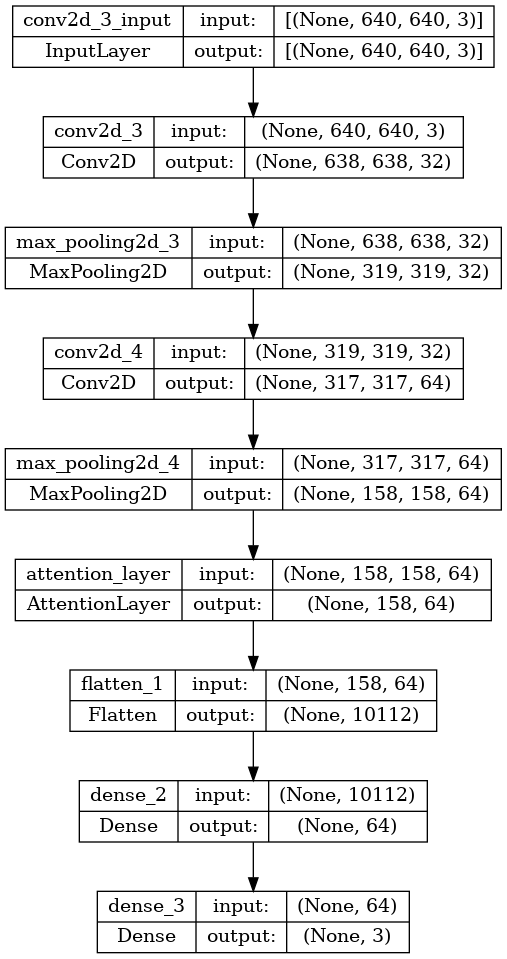

In [19]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(640, 640))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=16,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         target_size=(640, 640))

Found 2481 images belonging to 3 classes.
Found 537 images belonging to 3 classes.


In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2)

Epoch 1/15


2024-02-21 06:31:11.478558: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-02-21 06:31:11.479354: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-02-21 06:31:11.479364: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-02-21 06:31:11.479394: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-21 06:31:11.667140: W tenso

156/156 - 20s - loss: 1.0856 - accuracy: 0.3934 - val_loss: 1.0866 - val_accuracy: 0.4134 - 20s/epoch - 131ms/step
Epoch 2/15
156/156 - 17s - loss: 1.0689 - accuracy: 0.4071 - val_loss: 1.0726 - val_accuracy: 0.4153 - 17s/epoch - 108ms/step
Epoch 3/15
156/156 - 17s - loss: 1.0543 - accuracy: 0.4232 - val_loss: 1.0741 - val_accuracy: 0.3948 - 17s/epoch - 108ms/step
Epoch 4/15
156/156 - 17s - loss: 1.0386 - accuracy: 0.4494 - val_loss: 1.0683 - val_accuracy: 0.4153 - 17s/epoch - 108ms/step
Epoch 5/15
156/156 - 17s - loss: 1.0130 - accuracy: 0.4736 - val_loss: 1.0648 - val_accuracy: 0.4209 - 17s/epoch - 107ms/step
Epoch 6/15
156/156 - 17s - loss: 0.9787 - accuracy: 0.4986 - val_loss: 1.0830 - val_accuracy: 0.4358 - 17s/epoch - 109ms/step
Epoch 7/15
156/156 - 17s - loss: 0.9313 - accuracy: 0.5409 - val_loss: 1.1148 - val_accuracy: 0.4339 - 17s/epoch - 108ms/step
Epoch 8/15
156/156 - 17s - loss: 0.8644 - accuracy: 0.5865 - val_loss: 1.1382 - val_accuracy: 0.4432 - 17s/epoch - 110ms/step
Epo

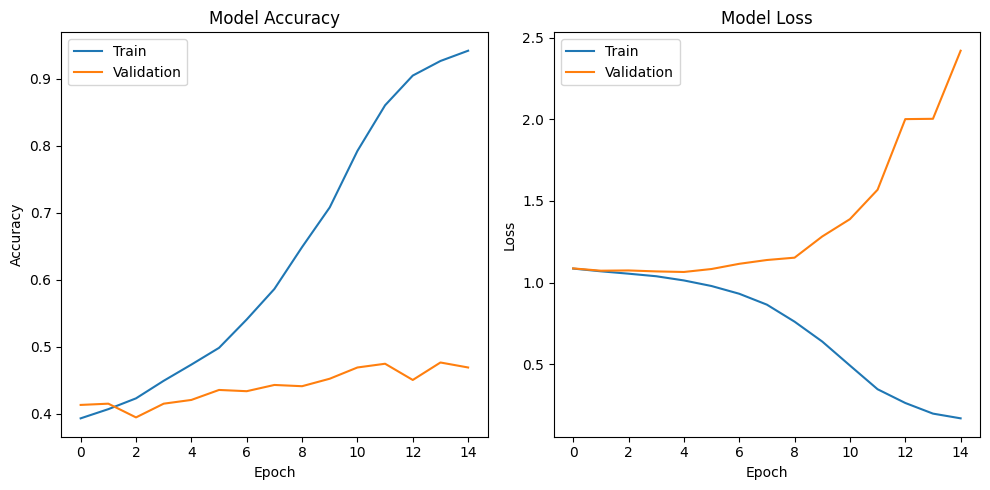

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
model.save("/home/foc-dba-38-0026-c/skin_detction/custom_model.h5")